In [1]:
import tensorflow as tf
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
from deepface import DeepFace
import pandas as pd
from pandas import plotting
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from core import * # please take a look at this file. In it i kept everything shared between notebooks, hence 'core'

In [2]:
verification_cache = {model.value: {} for model in FVM}
verification_cache

{'VGG-Face': {}, 'Facenet': {}, 'Facenet512': {}, 'OpenFace': {}}

In [3]:
# returns tuple -> (the result as dict , from_memory as a boolean)
def get_verification_result(comparison_key:str, model_name:str, img1_path:str, img2_path:str) -> (dict, bool):
    if comparison_key in verification_cache[model_name]:return verification_cache[model_name][comparison_key] , True
    else:return DeepFace.verify(img1_path = img1_path,img2_path = img2_path,model_name = model_name,
                                detector_backend = 'mtcnn', enforce_detection=False) , False

In [5]:
def verify_faces( model_type:FVM = FVM.vgg , gbu_type:GBU = GBU.good , limit:int=1100): # limit for faster testing
    model = model_type.value
    gbu = gbu_type.value
    
    genuine = []
    imposter = []
    
    query_path, target_path = get_query_target_paths(gbu_type)
    query_images = get_images_from_path(query_path)
    target_images = get_images_from_path(target_path)
    
    print(f"Verifying faces with {model} and {gbu}...")
    initial_time = datetime.now()
    
    for query_img in query_images[:limit]:
        query_person_id = int(query_img[:5])
        for target_img in target_images[:limit]:
            target_person_id = int(target_img[:5])
            is_truly_the_same_person = target_person_id == query_person_id
            
            comparison_key = tuple(sorted([target_person_id, query_person_id]))
            result, from_memory = get_verification_result(comparison_key, model_name = model,
                    img1_path = query_path + query_img,img2_path = target_path + target_img,) 
            if(not from_memory):verification_cache[model][comparison_key]=result
            
#             if(not is_truly_the_same_person and result[verified]) # FAR++ 
            
            if target_person_id == query_person_id:genuine.append(result)
            else:imposter.append(result)
        
    end_time = datetime.now()
    delta_time = end_time-initial_time
    print(delta_time)
    return genuine, imposter


gen, imp = verify_faces(limit=5)
 

Verifying faces with VGG-Face and Good...
0:00:00


In [16]:
print("genuine length: " + str(len(gen)))
print("imposter length: " + str(len(imp)))
verification_cache

genuine length: 17
imposter length: 8


{'VGG-Face': {(2463, 2463): {'verified': True,
   'distance': 0.226244913807363,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  (2463, 4202): {'verified': False,
   'distance': 0.5277763069383867,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  (4202, 4202): {'verified': True,
   'distance': 0.21100474654183587,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  (2463, 4203): {'verified': False,
   'distance': 0.583499399762712,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  (4202, 4203): {'verified': True,
   'distance': 0.24245874269690637,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  (4203, 4203): {'verified': True,
   'distance': 0.2018790844072904,
   'th

In [14]:
def plot_imposter_distribution(genuine_list, imposter_list, model:FVM , gbu:GBU ):
  fig, ax = plt.subplots()
  pd.DataFrame(genuine_list, columns = ['distance'])['distance'].plot.kde(ax=ax, title=f"{model.value} + {gbu.value}")
  pd.DataFrame(imposter_list, columns = ['distance'])['distance'].plot.kde(ax=ax, title=f"{model.value} + {gbu.value}",
                                                                                                        linestyle="-.")
  ax.legend(["genuine", "imposter"])
  ax.set_xlabel("Probability")

In [ ]:
def plot_false_acceptance_rate():

Verifying faces with VGG-Face and Good...
0:00:04.217313
Verifying faces with VGG-Face and Bad...
0:00:00
Verifying faces with VGG-Face and Ugly...
0:00:00
Verifying faces with Facenet and Good...
0:00:15.732194
Verifying faces with Facenet and Bad...
0:00:00.000997
Verifying faces with Facenet and Ugly...
0:00:00.000971
Verifying faces with Facenet512 and Good...
0:00:06.926218
Verifying faces with Facenet512 and Bad...
0:00:00
Verifying faces with Facenet512 and Ugly...
0:00:00
Verifying faces with OpenFace and Good...
0:00:04.364622
Verifying faces with OpenFace and Bad...
0:00:00
Verifying faces with OpenFace and Ugly...
0:00:00


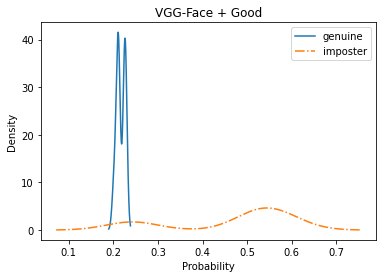

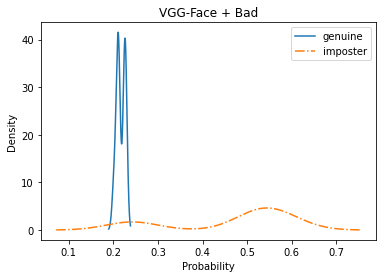

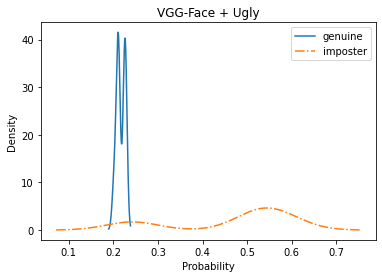

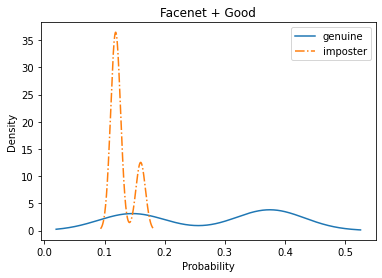

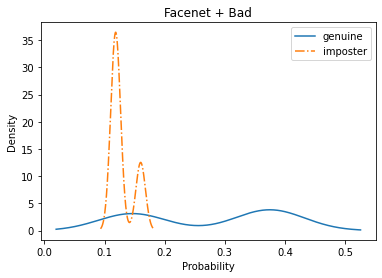

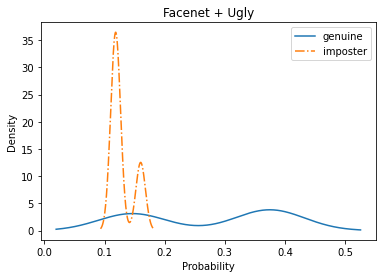

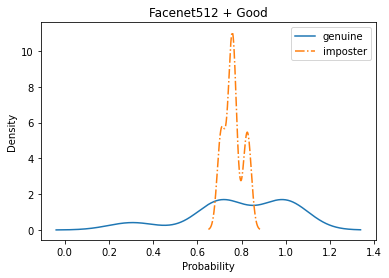

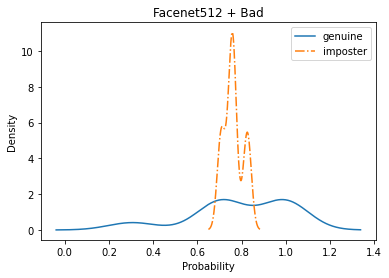

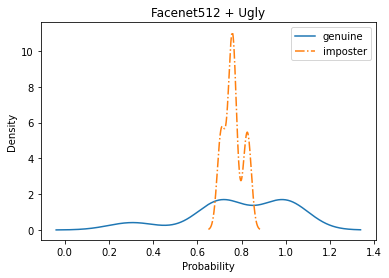

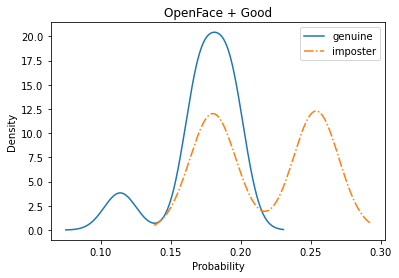

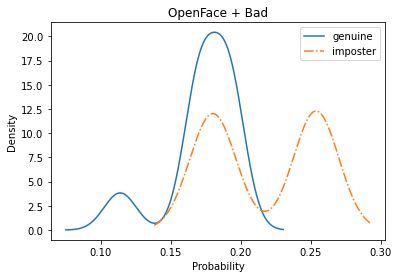

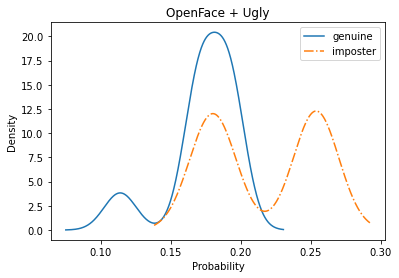

In [15]:
for face_veri_model in FVM:
    for gbu in GBU :
        genuine, imposter = verify_faces(face_veri_model, gbu, limit=10)
        plot(genuine, imposter, face_veri_model, gbu)